<a href="https://colab.research.google.com/github/PosgradoMNA/Proyecto_A01794099/blob/main/Avance4_Equipo12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

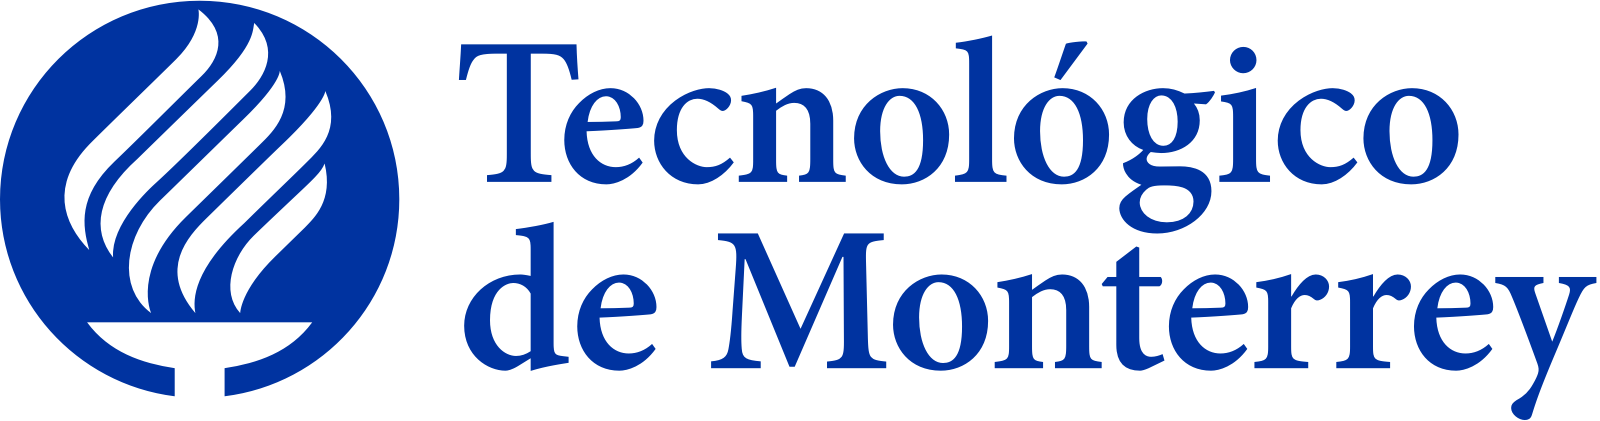

# Maestría en Inteligencia Artificial Aplicada
## Tecnológico de Monterrey
## TC5035.10 – Proyecto Integrador

### Avance 4 - Modelos Alternativos: Reconocimiento robusto de comandos de voz en robots mediante paráfrasis y clasificación k-NN

**Profesores titulares: Dra. Grettel Barceló Alonso, Dr. Luis Eduardo Falcón Morales**

**Profesor asistente: Mtra. Verónica Sandra Guzmán de Valle**


**Equipo 12:**
*   Laura Irán González Ojeda - **A01794099**

#### Indroducción

En el entregable anterior, **Avance 3 - Baseline** ([GitHub link](https://github.com/PosgradoMNA/Proyecto_A01794099/blob/main/Avance3_Equipo12.ipynb)), se comparó el rendimiento de dos modelos avanzados de procesamiento de lenguaje natural: SBERT (Sentence-BERT) y LaBSE (Language-agnostic BERT Sentence Embedding). Estos modelos se evaluaron con el objetivo de detectar comandos verbales que un robot pueda interpretar y ejecutar.

Dado el enfoque del proyecto, que busca desarrollar un sistema robusto para el reconocimiento de comandos verbales en robots, se ha decidido simplificar el análisis y reducir la cantidad de modelos evaluados. Para esta fase, se propone añadir un tercer modelo a la comparación: ValGPT, una herramienta interna de Intel basada en el motor del LLM GPT-4.

ValGPT ha sido identificado como una solución prometedora dentro de Intel, ya que aprovecha las capacidades avanzadas de GPT-4. Para evaluarlo, se llevará a cabo un ejercicio conectándose a su API, generando prompts, y midiendo tanto la rapidez como la precisión en la clasificación de comandos. Esto permitirá realizar una comparación más exhaustiva entre SBERT, LaBSE y ValGPT, ayudando a determinar cuál de los tres modelos es más adecuado para el objetivo final: un sistema robusto de reconocimiento de comandos de voz mediante paráfrasis y clasificación k-NN.

**Consideraciones Importantes**

*Para respetar la confidencialidad con la compañía Intel, en este ejercicio se añadirá el mismo prompt introducido en ValGPT, pero para demostrar los hallazgos, se realizará el request a la API open source de OpenAI para evitar la violación de accesos y divulgación de información.*

*Otro tema de confidencialidad con la empresa son los Datos. El dataset utilizado para estos ejercicios, son un ejemplo para replicar el procedimiento que se está trabajando con la empresa. El dataset manejado para el proyecto con Intel tiene una protección de datos Intel Top Secret, por lo cual no se puede divulgar. Pero la compañía autorizó utilizar datos similares (comandos y labels similares) con el mismo layout y cantidad de datos del dataset original.*

In [ ]:
!pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.52.0
    Uninstalling openai-1.52.0:
      Successfully uninstalled openai-1.52.0


In [ ]:
#Importación de Librerías
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import openai

#### Preparación de los datos

Para esta etapa del proyecto, el dataset se incrementó aproximadamente un 97%, pasando de 81 comandos a 187 inputs para enriquecer más a los modelos y puedan determinar una mejor clasificación.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta del archivo CSV en Google Drive
csv_file_path = '/content/drive/My Drive/Proyecto Integrador/Proyecto/data.csv'

# Leer el archivo CSV
df = pd.read_csv(csv_file_path)

# Mostrar las primeras filas del DataFrame
df.head()

command     action
0        Shift the arm to the left  move_left
1     Position the arm to the left  move_left
2        Guide the arm to the left  move_left
3  Direct the arm towards the left  move_left
4       Adjust the arm to the left  move_left

In [ ]:
df.describe()

command      action
count                         187         187
unique                        187          21
top     Shift the arm to the left  no_command
freq                            1          40

#### Cargar los modelos: SBERT y LaBSE

In [ ]:
# Load SBERT model from Hugging Face
tokenizer_sbert = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_sbert = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
# Load LaBSE model from Hugging Face
tokenizer_labse = AutoTokenizer.from_pretrained('sentence-transformers/LaBSE')
model_labse = AutoModel.from_pretrained('sentence-transformers/LaBSE')

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

In [ ]:
def get_embeddings(texts, tokenizer, model):
    # Tokenize the texts and get embeddings
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

def classify_command(sentence, command_list, command_embeddings, tokenizer, model, threshold):
    # Tokenizar y codificar la oración
    inputs = tokenizer(sentence, return_tensors='pt')
    sentence_embedding = model(**inputs).last_hidden_state.mean(dim=1)

    # Compute cosine similarity with all command embeddings
    similarity_matrix = cosine_similarity(sentence_embedding.cpu().detach().numpy(), command_embeddings.cpu().detach().numpy())
    distance_matrix = 1 - similarity_matrix

    # Find the index of the most similar distance
    min_distance_idx = np.argmin(distance_matrix)
    min_distance = distance_matrix[0][min_distance_idx]

    # Check if the minimum distance is within the threshold
    if min_distance <= threshold:
        predicted_command = command_list[min_distance_idx]
    else:
        predicted_command = None  # or some other value indicating no valid match

    return predicted_command, min_distance

#### Generar embeddings para ambos modelos

In [ ]:
# Compute embeddings for all commands using SBERT
command_embeddings_sbert = get_embeddings(df['command'].tolist(), tokenizer_sbert, model_sbert)
# Compute embeddings for all commands using LaBSE
command_embeddings_labse = get_embeddings(df['command'].tolist(), tokenizer_labse, model_labse)

In [ ]:
# Define function to compute distance matrix
def compute_distance_matrix(command_embeddings):
    similarity_matrix = cosine_similarity(command_embeddings.cpu().numpy())
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance
    return distance_matrix

#Calcular la desviacion estandar
def compute_average_distance(distance_matrix):
    # Extract the upper triangular part of the matrix, excluding the diagonal
    upper_triangular_indices = np.triu_indices_from(distance_matrix, k=1)
    upper_triangular_values = distance_matrix[upper_triangular_indices]

    # Calculate the average distance
    average_distance = np.mean(upper_triangular_values)

    return average_distance

In [ ]:
# Compute distance matrix for SBERT
distance_matrix_sbert = compute_distance_matrix(command_embeddings_sbert)
# Compute distance matrix for LaBSE
distance_matrix_labse = compute_distance_matrix(command_embeddings_labse)

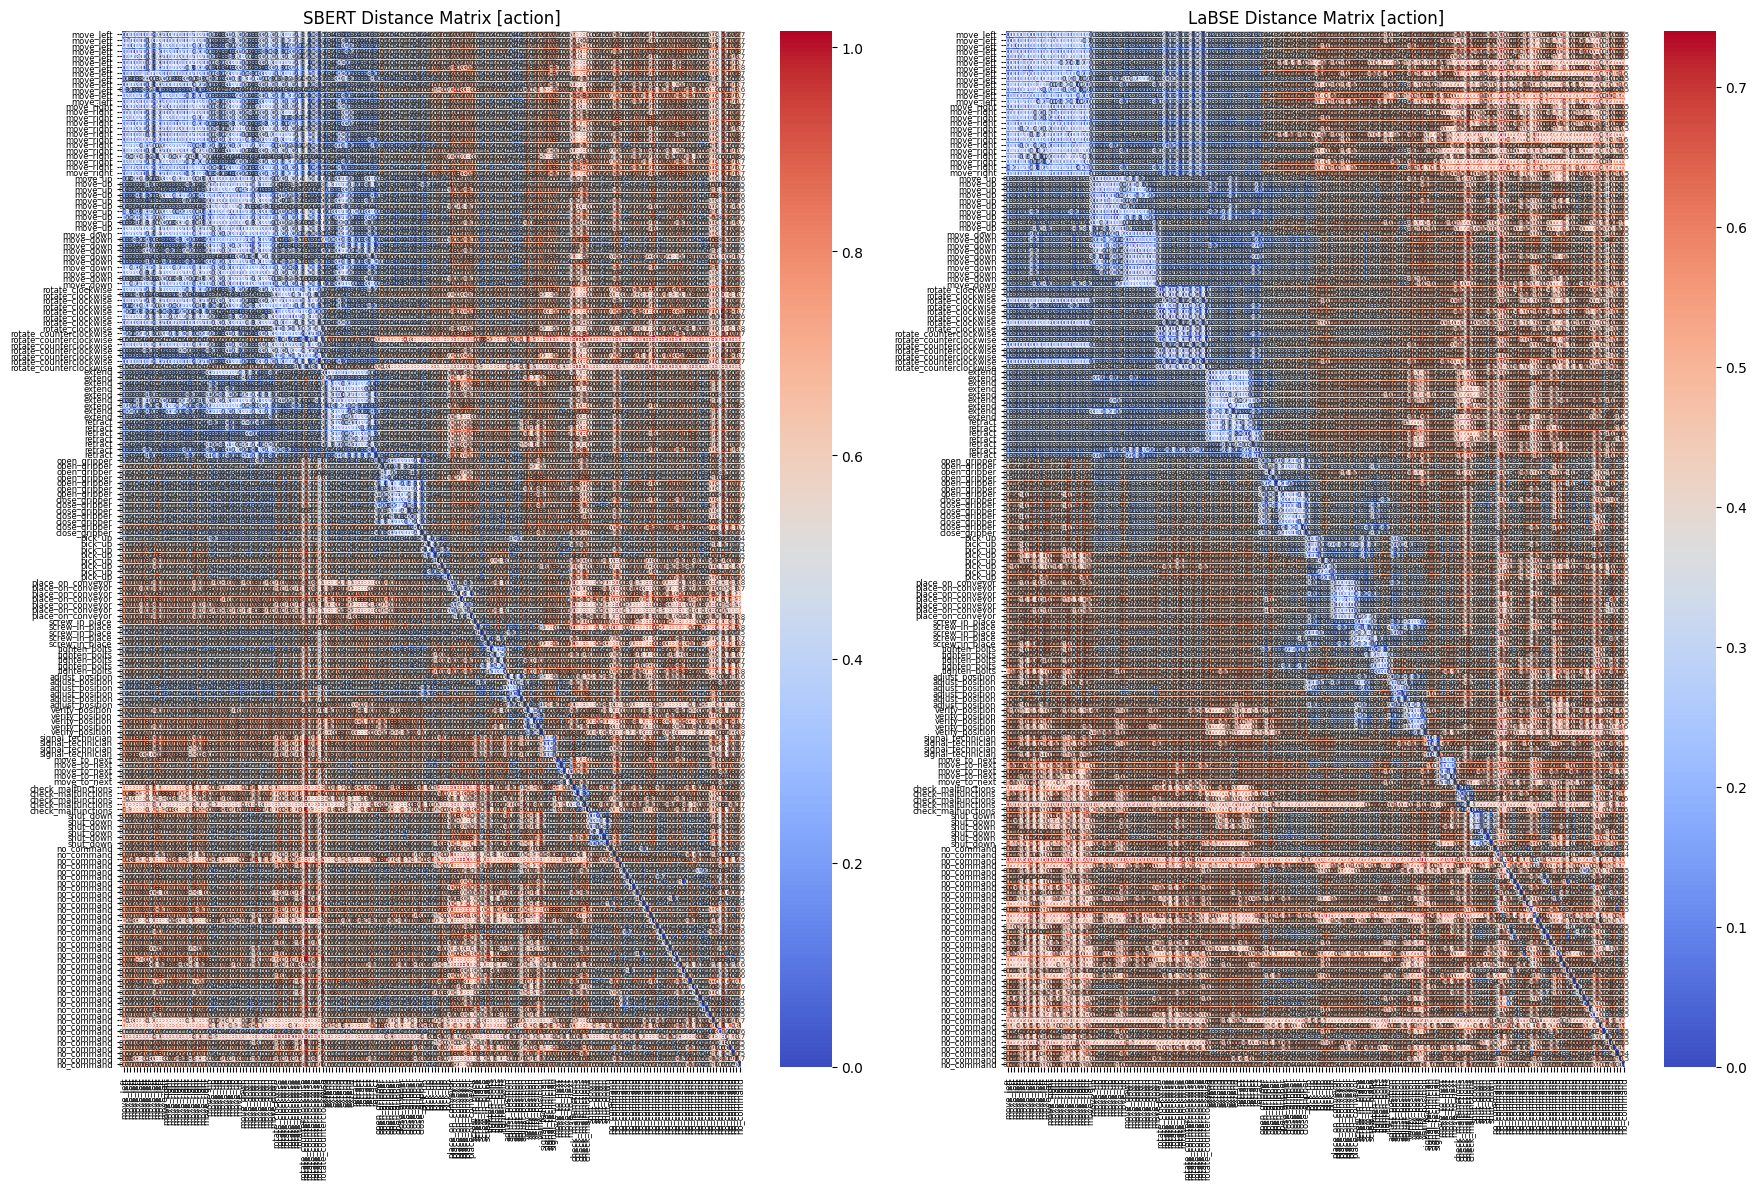

In [ ]:
# Plot distance matrices
plt.figure(figsize=(18, 12))

plt.subplot(1, 2, 1)
sns.heatmap(distance_matrix_sbert, xticklabels=df['action'], yticklabels=df['action'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('SBERT Distance Matrix [action]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.subplot(1, 2, 2)
sns.heatmap(distance_matrix_labse, xticklabels=df['action'], yticklabels=df['action'], cmap='coolwarm', annot=True, fmt=".1f", annot_kws={"size": 5})
plt.title('LaBSE Distance Matrix [action]')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

#### Evaluación de modelos: SBERT y LaBSE

In [ ]:
def classify_command(sentence, command_list, action_list, command_embeddings, tokenizer, model, threshold):
    # Tokenizar y codificar la oración
    inputs = tokenizer(sentence, return_tensors='pt')
    sentence_embedding = model(**inputs).last_hidden_state.mean(dim=1)

    # Compute cosine similarity with all command embeddings
    similarity_matrix = cosine_similarity(sentence_embedding.cpu().detach().numpy(), command_embeddings.cpu().detach().numpy())
    distance_matrix = 1 - similarity_matrix

    # Find the index of the most similar distance
    min_distance_idx = np.argmin(distance_matrix)
    min_distance = distance_matrix[0][min_distance_idx]

    # Check if the minimum distance is within the threshold
    if min_distance <= threshold:
        predicted_action = action_list[min_distance_idx]
    else:
        predicted_action = 'None'  # No valid match

    return predicted_action, min_distance


In [ ]:
def evaluate_model(command_list, action_list, command_embeddings, dataset, tokenizer, model, threshold):
    true_labels = []
    predicted_labels = []

    for _, row in dataset.iterrows():
        sentence = row['command']
        label = row['action']

        # Predecir la acción utilizando classify_command
        predicted_action, _ = classify_command(sentence, command_list, action_list, command_embeddings, tokenizer, model, threshold)

        predicted_labels.append(predicted_action)
        true_labels.append(label)

    # Calcular métricas de evaluación
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    return accuracy, f1, conf_matrix

In [ ]:
# Umbral de distancia para clasificación
command_list = df['command'].tolist()  # Lista de comandos
action_list = df['action'].tolist()  # Lista de acciones correspondientes
threshold = 0.4

Accuracy SBERT: 0.983957219251337
F1-Score SBERT: 0.9838412646968797


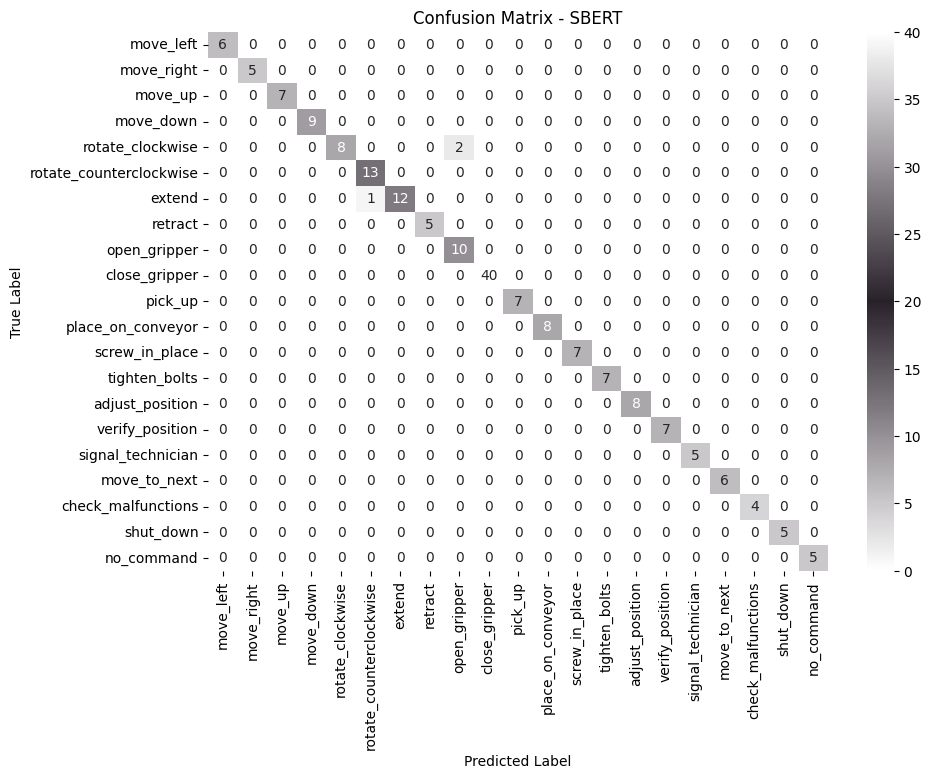

In [ ]:
# Evaluar el modelo SBERT
accuracy, f1, conf_matrix = evaluate_model(command_list, action_list, command_embeddings_sbert, df, tokenizer_sbert, model_sbert, threshold)

print(f"Accuracy SBERT: {accuracy}")
print(f"F1-Score SBERT: {f1}")
# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
colormap = sns.diverging_palette(250, 120, l=200, center="dark", as_cmap=True)
sns.heatmap(conf_matrix, annot=True,fmt='d', xticklabels=df['action'].unique(), yticklabels=df['action'].unique(), cmap=colormap)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - SBERT')
plt.show()

Accuracy LaBSE: 1.0
F1-Score LaBSE: 1.0


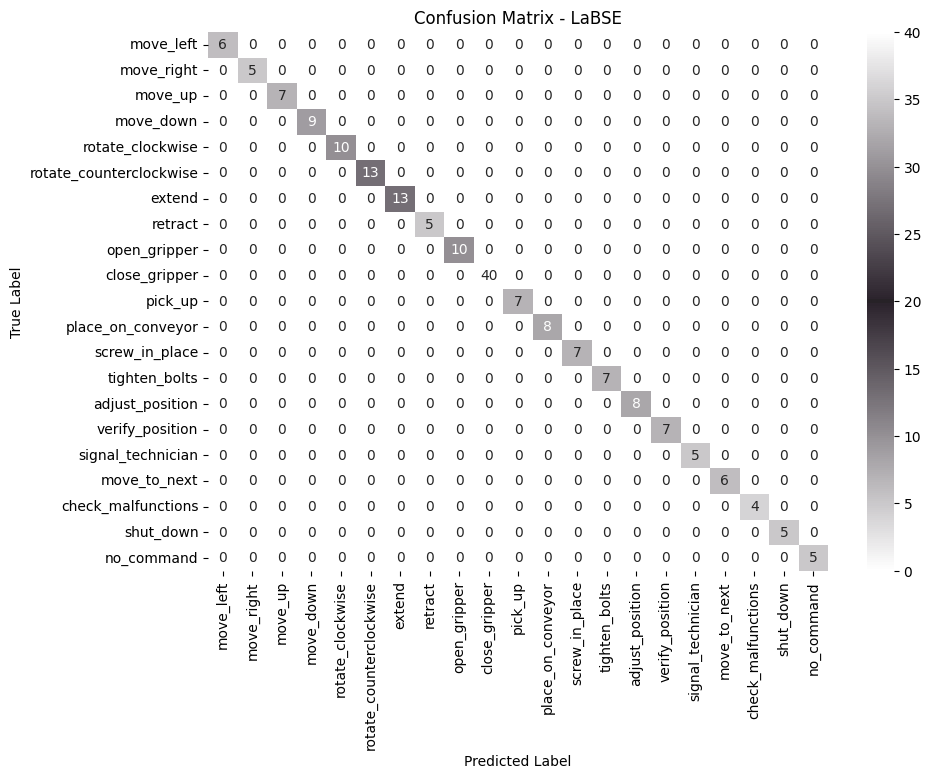

In [ ]:
# Evaluar el modelo LaBSE
accuracy, f1, conf_matrix = evaluate_model(command_list, action_list, command_embeddings_labse, df, tokenizer_labse, model_labse, threshold)

print(f"Accuracy LaBSE: {accuracy}")
print(f"F1-Score LaBSE: {f1}")
# Mostrar la matriz de confusión
plt.figure(figsize=(10, 7))
colormap = sns.diverging_palette(250, 120, l=200, center="dark", as_cmap=True)
sns.heatmap(conf_matrix, annot=True,fmt='d', xticklabels=df['action'].unique(), yticklabels=df['action'].unique(), cmap=colormap)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - LaBSE')
plt.show()

#### Ajustar los dos mejores modelos: SBERT Y LaBSE

Dada la naturaleza del proyecto, el parámetro a ajustar es el **Threshold** para un mejor rendimiento y predicción del "label", o sea la acción que se desea que el robot ejecute al recibir un comando.
A continuación, se observa un ejercicio para determinar el mejor Threshold para cada modelo y así maximizar la métrica F1-Score.

In [ ]:
# Ajuste del umbral para maximizar F1-Score
def tune_threshold(command_list, action_list, command_embeddings, dataset, tokenizer, model, thresholds):
    best_f1 = 0
    best_threshold = None

    for threshold in thresholds:
        true_labels = []
        predicted_labels = []

        # Iterar sobre el DataFrame utilizando iterrows
        for _, row in dataset.iterrows():
            sentence = row['command']
            label = row['action']

            # Predecir la acción utilizando classify_command
            predicted_command, _ = classify_command(sentence, command_list, action_list, command_embeddings, tokenizer, model, threshold)

            # Añadir la predicción y la etiqueta real
            predicted_labels.append(predicted_command if predicted_command else 'None')
            true_labels.append(label)

        # Calcular F1-Score ponderado
        f1 = f1_score(true_labels, predicted_labels, average='weighted')

        # Actualizar el mejor umbral si el F1 mejora
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [ ]:
# Rango de umbrales para probar
thresholds = np.linspace(0.1, 0.5, 10)

# Probar con SBERT
best_sbert_threshold, best_sbert_f1 = tune_threshold(command_list, action_list, command_embeddings_sbert, df, tokenizer_sbert, model_sbert, thresholds)
print(f"Mejor umbral SBERT: {best_sbert_threshold}, Mejor F1-Score: {best_sbert_f1}")

# Probar con LaBSE
best_labse_threshold, best_labse_f1 = tune_threshold(command_list, action_list, command_embeddings_labse, df, tokenizer_labse, model_labse, thresholds)
print(f"Mejor umbral LaBSE: {best_labse_threshold}, Mejor F1-Score: {best_labse_f1}")


Mejor umbral SBERT: 0.3666666666666667, Mejor F1-Score: 0.9838412646968797
Mejor umbral LaBSE: 0.1, Mejor F1-Score: 1.0


#### Evaluación de opción adicional: Integración de un LLM (OpenAI - GPT), en Intel: ValGPT

In [ ]:
openai.api_key = "OPEN I KEY"

In [ ]:
# Define the prompt for command classification
prompt = '''
You have the following list of commands with their corresponding actions:

1. "Shift the arm to the left" -> move_left
2. "Shift the arm to the right" -> move_right
3. "Lift the arm upwards" -> move_up
4. "Move the arm downwards" -> move_down
5. "Turn the arm in a clockwise direction" -> rotate_clockwise
6. "Turn the arm counterclockwise" -> rotate_counterclockwise
7. "Extend the arm towards me" -> extend
8. "Pull the arm away from me" -> retract
9. "Release the grip" -> open_gripper
10. "Close the gripper tightly" -> close_gripper
11. "Lift the item" -> pick_up
12. "Set the object on the conveyor" -> place_on_conveyor
13. "Secure the object in place" -> screw_in_place
14. "Tighten the screws" -> tighten_bolts
15. "Adjust the placement of the item" -> adjust_position
16. "Check the object's location" -> verify_position
17. "Notify the technician when done" -> signal_technician
18. "Move on to the next item" -> move_to_next
19. "Look for any issues" -> check_malfunctions
20. "Power down the system" -> shut_down

Given an input command, classify it within this list and return the corresponding action.

Input command: "Guide the arm to the left"
'''

# Send request to OpenAI API
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are an AI that classifies commands into predefined actions."},
    {"role": "user", "content": prompt}
  ]
)

# Print the classified action
print(response['choices'][0]['message']['content'])


RateLimitError: You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.

#### Conclusiones

En este ejercicio, se compararon dos modelos de lenguaje, SBERT y LaBSE, para la clasificación de comandos basados en la similitud coseno. Los resultados muestran que LaBSE logró un F1-Score perfecto de 1.0 con un umbral óptimo de 0.1, mientras que SBERT obtuvo un F1-Score de 0.9838 con un umbral de 0.3667. A pesar de los resultados sobresalientes de LaBSE en este dataset de ejemplo, es importante señalar que en el dataset real utilizado para el proyecto con Intel, SBERT presentó un rendimiento superior debido a su capacidad para capturar mejor la semántica en los comandos.

Es relevante destacar que el dataset utilizado para este ejercicio es solo un ejemplo diseñado para replicar el procedimiento empleado en el proyecto real. El dataset original utilizado en colaboración con Intel está protegido bajo la política de datos Intel Top Secret, lo que impide su divulgación. No obstante, la empresa autorizó el uso de datos simulados con una estructura y cantidad similares para la realización de pruebas y demostraciones como esta.

Por último, la evaluación del modelo de lenguaje GPT como generador de prompts en este ejercicio fue exitosa y constituye una opción viable a explorar en el proyecto actual para la mejora en la detección y clasificación de comandos en tiempo real.

#### Referencias
Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O´Reilly Media. https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/